In [159]:
# import all modules here
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torchvision.transforms as transforms
from torchvision import models

import warnings
warnings.filterwarnings('ignore')

In [89]:
def load_data(number: int, data_type: str, part: str, X_only = False, y_only = False):
    """
    Loads image and label data based on the provided number, type, and part.
    Parameters:
        number (int): A number from 1 to 10, specifying the dataset part.
        data_type (str): A string, either 'eval' or 'train', specifying the dataset type.
        part (str): A string, either 'one' or 'two', specifying the dataset part.
    Returns:
        tuple: A tuple containing two arrays, images and labels if available, otherwise only images.
    Raises:
        ValueError: If `number` is not between 1 and 10, `data_type` is not 'eval' or 'train',
                    or `part` is not 'one' or 'two'.
    """

    # Check if inputs are valid
    if number not in range(1, 11):
        raise ValueError("Number must be between 1 and 10.")
    if data_type not in ["eval", "train"]:
        raise ValueError("Type must be 'eval' or 'train'.")
    if part not in ["one", "two"]:
        raise ValueError("Part must be 'one' or 'two'.")

    # Construct the path
    path = f'dataset/part_{part}_dataset/{data_type}_data/{number}_{data_type}_data.tar.pth'
    
    # Load data
    data = torch.load(path)
    images = data.get('data')  # Expected shape (2500, 32, 32, 3)
    
    if X_only == True:
        return images

    if 'targets' in data:
        labels = data['targets']  # Expected shape (2500,)
        if y_only == True: return labels
        return images, labels
    else:
        return images  # Return only images if labels are not present

In [90]:
images, labels = load_data(1, "train", "one")

In [91]:
#Number of unique labels
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [92]:
def visualize_images(images, labels, num_images=30):
    """
    Visualizes the first `num_images` images and their corresponding labels in a grid.
    Parameters:
        images : ndarray, labels : ndarray.
        num_images (int): Number of images to display (default is 30).
    """
    # Set up the grid for displaying images
    num_images = min(num_images, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols 
    
    plt.figure(figsize=(10, rows * 2))  # Adjust figure size based on number of rows
    
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap= 'gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

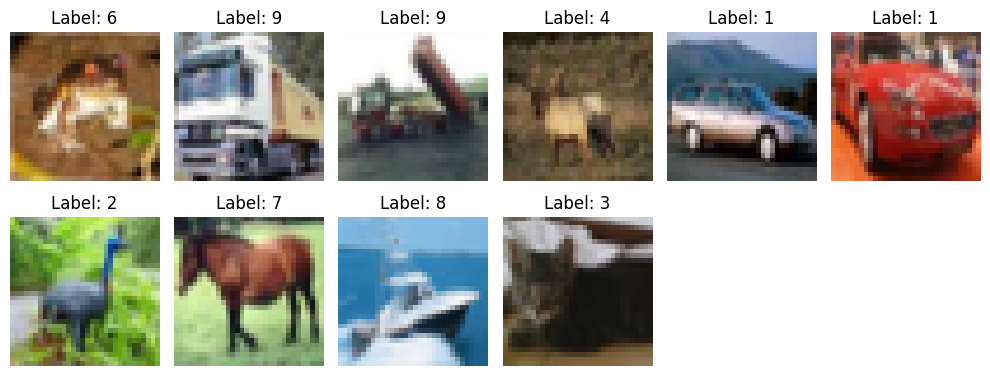

In [93]:
visualize_images(images, labels, 10)

In [94]:
# def convert_to_grayscale(images):
#     """
#     Converts a batch of RGB images to grayscale.
#     Parameters: images -> (N, 32, 32, 3) Returns: ndarray -> (N, 32, 32)
#     """
#     N = len(images)
#     grayscale_images = np.zeros((N, 32, 32), dtype = np.uint8)

#     for k in range(N):
#         for i in range(len(images[k])):
#             for j in range(len(images[k][0])):
#                 grayscale_images[k][i][j] = 0.3 * images[k][i][j][0] + 0.59 * images[k][i][j][1] + 0.11 * images[k][i][j][2]
    
#     return grayscale_images

# Above code is also covert_to_grayscale but it's execution time is slow

def convert_to_grayscale(images):
    N = images.shape[0] 
    grayscale_images = np.zeros((N, 32, 32), dtype=np.uint8) 

    grayscale_images = (0.2989 * images[:, :, :, 0] + 
                        0.5870 * images[:, :, :, 1] + 
                        0.1140 * images[:, :, :, 2]).astype(np.uint8)

    return grayscale_images

In [95]:
images = convert_to_grayscale(images)
images.shape

(2500, 32, 32)

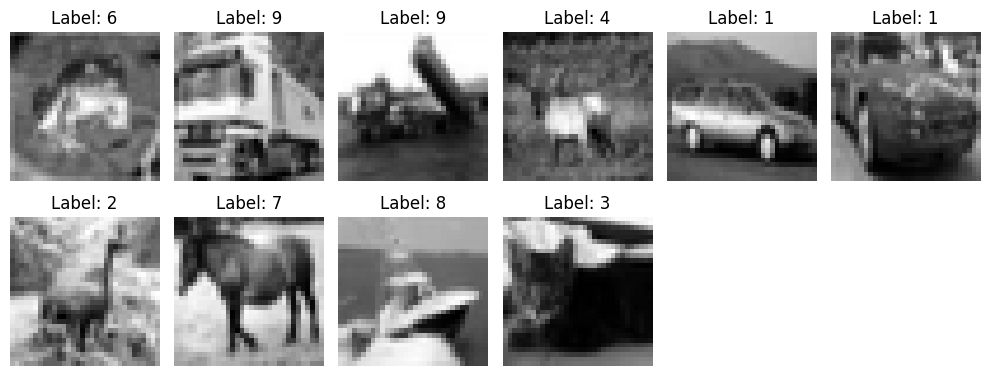

In [96]:
visualize_images(images, labels, 10)

In [97]:
 # Flatten each 32x32 image to a 1024-dimensional vector
N = images.shape[0]
flattened_images = images.reshape(N, -1) 

In [98]:
flattened_images.shape

(2500, 1024)

## LwP model with Euclidean distance

In [99]:
class LwP_euclidean:
    def __init__(self, n_prototypes):
        """
        Parameters:
            n_prototypes (int): Number of distinct labels.
        """
        self.n_prototypes = n_prototypes
        self.prototypes = None
        self.labels = None
        self.class_counts = None  # Track the count of samples per class
        self.label_to_index = {}  # Maps each label to an index in the prototypes array

    def fit(self, X, y):
        """
        Trains the model by finding prototypes based on the training data.
        Parameters:
            X (ndarray) -> (N, 1024)
            y (ndarray): Labels -> (N,)
        """
        unique_labels = np.unique(y)
        self.labels = unique_labels
        self.prototypes = np.zeros((self.n_prototypes, X.shape[1]))  # Placeholder for prototypes
        self.class_counts = np.zeros(self.n_prototypes, dtype=int)

        # Create label-to-index mapping
        self.label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

        # Calculate prototypes for each label
        for label in unique_labels:
            class_samples = X[y == label]
            if len(class_samples) > 0:
                idx = self.label_to_index[label]
                self.prototypes[idx] = np.mean(class_samples, axis=0)
                self.class_counts[idx] = len(class_samples)

    def euclidean_distance(self, a, b):
        """
        Parameters:
            a (ndarray): First vector.
            b (ndarray): Second vector.
        Returns:
            float: Euclidean distance between a and b.
        """
        return np.sqrt(np.sum((a - b) ** 2))

    def update(self, X_new, y_new):
        """
        Updates the model with new training examples.
        Parameters:
            X_new (ndarray): New samples -> (M, 1024)
            y_new (ndarray): New labels -> (M,)
        """
        for label in np.unique(y_new):
            new_samples = X_new[y_new == label]
            n_new = len(new_samples)
            if n_new > 0:
                idx = self.label_to_index.get(label)
                if idx is None:
                    raise ValueError(f"Label {label} not found in the model. Ensure that all labels are initialized in fit.")

                current_count = self.class_counts[idx]
                total_count = current_count + n_new
                new_mean = np.mean(new_samples, axis=0)
                
                # Update prototype as a weighted mean
                self.prototypes[idx] = (current_count * self.prototypes[idx] + n_new * new_mean) / total_count
                self.class_counts[idx] = total_count

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for i in range(n_samples):
            distances = np.zeros(len(self.labels))
            for j, prototype in enumerate(self.prototypes):
                distances[j] = self.euclidean_distance(X[i], prototype)
            predictions[i] = self.labels[np.argmin(distances)]

        return predictions

In [100]:
# LwP model with euclidean distance on flattened_images
model = LwP_euclidean(n_prototypes=10)
model.fit(flattened_images, labels)

# loading eval dataset
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = convert_to_grayscale(X_eval)
X_eval = X_eval.reshape(X_eval.shape[0], -1)

# predicting on it
predictions = model.predict(X_eval)
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 23.80%


### LwP model with Mahanolobis Distance

In [204]:
class LwP_Mahalanobis:
    def __init__(self, n_prototypes):
        """
        Parameters:
            n_prototypes (int): Number of distinct labels.
        """
        self.n_prototypes = n_prototypes
        self.prototypes = None
        self.labels = None
        self.inv_cov_matrix = None
        self.class_counts = None  # Track the count of samples per class
        self.label_to_index = {}  # Maps each label to an index in the prototypes array

    def fit(self, X, y):
        """
        Trains the model by finding prototypes based on the training data.
        Parameters:
            X (ndarray) -> (N, 1024)
            y (ndarray): Labels -> (N,)
        """
        unique_labels = np.unique(y)
        self.labels = unique_labels
        self.prototypes = np.zeros((self.n_prototypes, X.shape[1]))  # Placeholder for prototypes
        self.class_counts = np.zeros(self.n_prototypes, dtype=int)

        # Create label-to-index mapping
        self.label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

        # Calculate prototypes for each label
        for label in unique_labels:
            class_samples = X[y == label]
            if len(class_samples) > 0:
                idx = self.label_to_index[label]
                self.prototypes[idx] = np.mean(class_samples, axis=0)
                self.class_counts[idx] = len(class_samples)

        # Compute the covariance matrix of the dataset and its inverse
        covariance_matrix = np.cov(X, rowvar=False)
        self.inv_cov_matrix = np.linalg.inv(covariance_matrix)

    def mahalanobis_distance(self, a, b, name='maha'):
        """
        Parameters:
            a (ndarray): First vector.
            b (ndarray): Second vector.
        Returns:
            float: Mahalanobis distance between a and b.
        """
        diff = a - b
        mat = self.inv_cov_matrix if name == 'maha' else np.eye(a.shape[0])
        return np.sqrt(np.dot(np.dot(diff, mat), diff.T))

    def update(self, X_new, y_new, update_inv_cov=True):
        """
        Updates the model with new training examples.
        Parameters:
            X_new (ndarray): New samples -> (M, 1024)
            y_new (ndarray): New labels -> (M,)
        """
        for label in np.unique(y_new):
            new_samples = X_new[y_new == label]
            n_new = len(new_samples)
            if n_new > 0:
                idx = self.label_to_index.get(label)
                if idx is None:
                    raise ValueError(f"Label {label} not found in the model. Ensure that all labels are initialized in fit.")

                current_count = self.class_counts[idx]
                total_count = current_count + n_new
                new_mean = np.mean(new_samples, axis=0)
                
                # Update prototype as a weighted mean
                self.prototypes[idx] = (current_count * self.prototypes[idx] + n_new * new_mean) / total_count
                self.class_counts[idx] = total_count

        # Update covariance matrix based on the combined data
        if update_inv_cov:
            combined_X = np.vstack([self.prototypes, X_new])
            covariance_matrix = np.cov(combined_X, rowvar=False)
            self.inv_cov_matrix = np.linalg.inv(covariance_matrix)

    def dist_mat(self, X):
        n_samples = X.shape[0]
        
        res = []
        for i in range(n_samples):
            distances = np.zeros(len(self.labels))
            for j, prototype in enumerate(self.prototypes):
                distances[j] = self.mahalanobis_distance(X[i], prototype)
            res.append(distances)
        
        return res

    def softmax_mat(self, X):
        dist_mat = self.dist_mat(X)

        for i in dist_mat:
            total = 0
            for j in i:
                total += np.exp(j)
            
            for j in range(len(i)):
                i[j] = np.exp(i[j]) / total
        
        return dist_mat

    def next_gen(self, X, thres=0.8):
        sfm = self.softmax_mat(X)
        X_ret = []
        y_ret = []

        for i, x in enumerate(X):
            prob_idx = np.argmax(sfm[i])
            prob = sfm[i][prob_idx]
            if (prob < thres): continue

            X_ret.append(x)
            y_ret.append(prob_idx) # append class label
        
        return np.asanyarray(X_ret), np.asanyarray(y_ret)

    def top_k(self, X, k):
        sfm = self.softmax_mat(X)
        X2 = []

        for i, Xi in enumerate(sfm):
            X2.append([np.max(Xi), i])
        
        X2 = sorted(X2)
        X2 = X2[-1 * k : ]

        X_res = []
        y_res = []

        for x in X2:
            X_res.append(X[x[1]])
            y_res.append(np.argmax(sfm[x[1]]))
        
        return np.asanyarray(X_res), np.asanyarray(y_res)

    def predict(self, X, name='maha'):
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for i in range(n_samples):
            distances = np.zeros(len(self.labels))
            for j, prototype in enumerate(self.prototypes):
                distances[j] = self.mahalanobis_distance(X[i], prototype, name)
            predictions[i] = self.labels[np.argmin(distances)]

        return predictions


In [102]:
# LwP model with mahalanobis distance on flattened_images
model = LwP_Mahalanobis(n_prototypes=10)
model.fit(flattened_images, labels)

# loading eval dataset
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = convert_to_grayscale(X_eval)
X_eval = X_eval.reshape(X_eval.shape[0], -1)

# predicting on it
predictions = model.predict(X_eval)
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 15.64%


## Trying new Approach by extracting features using Neural Network

In [103]:
def extract_features_cuda(images):
    """
    Extract features from a batch of CIFAR-10 images using a pre-trained ResNet18 model.

    Args:
        images (numpy.ndarray): A 4D array of shape (N, 32, 32, 3), where N is the number of images.

    Returns:
        torch.Tensor: A 2D tensor of shape (N, 512) containing the extracted features.
    """
    
    batch_size = 5
    # Step 1: Convert the input images to a tensor and apply transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert to PIL Image
        transforms.Resize(224),   # Resize to 224x224
        transforms.ToTensor(),     # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), 
        transforms.RandomHorizontalFlip(0.1),
    ])

    # Transform each image and create a tensor
    transformed_images = torch.stack([transform(images[i]) for i in range(images.shape[0])])

    # Step 2: Load pre-trained ResNet18 model
    model = models.resnet34(pretrained=True)
    model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the classification layer
    model.eval()  # Set the model to evaluation mode

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(device)
    model.to(device)
    transformed_images = transformed_images.to(device)

    torch.cuda.set_per_process_memory_fraction(1.0)

    # Step 3: Feature extraction
    features_list = []
    with torch.no_grad():
        for i in range(0, transformed_images.size(0), batch_size):
            torch.cuda.empty_cache()
            batch_images = transformed_images[i : i + batch_size]  # Get features
            batch_features = model(batch_images)  # Flatten the output
            features_list.append(batch_features.view(batch_features.size(0), -1))

    return features_list

In [104]:
def extract_features_mac(images):
    """
    Extract features from a batch of CIFAR-10 images using a pre-trained ResNet34 model on MPS.

    Args:
        images (numpy.ndarray): A 4D array of shape (N, 32, 32, 3), where N is the number of images.

    Returns:
        torch.Tensor: A 2D tensor of shape (N, 512) containing the extracted features.
    """
    
    batch_size = 25
    # Step 1: Convert the input images to a tensor and apply transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert to PIL Image
        transforms.Resize(224),   # Resize to 224x224
        transforms.ToTensor(),     # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        transforms.RandomHorizontalFlip(0.1),
    ])

    # Transform each image and create a tensor
    transformed_images = torch.stack([transform(images[i]) for i in range(images.shape[0])])

    # Step 2: Load pre-trained ResNet34 model
    model = models.resnet34(pretrained=True)
    model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the classification layer
    model.eval()  # Set the model to evaluation mode

    # Use MPS if available, otherwise fall back to CPU
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    print(device, end=" ")
    transformed_images = transformed_images.to(device)

    # Step 3: Feature extraction
    features_list = []
    with torch.no_grad():
        for i in range(0, transformed_images.size(0), batch_size):
            batch_images = transformed_images[i : i + batch_size]  # Get batch of images
            batch_features = model(batch_images)  # Extract features
            features_list.append(batch_features.view(batch_features.size(0), -1))

    return features_list

In [105]:
def extract_features(images):
     if torch.backends.mps.is_available() :
          return extract_features_mac(images)
     return extract_features_cuda(images)

In [106]:
X_train, y_train = load_data(1, "train", "one")
X_train = [t.cpu().numpy() for t in extract_features(X_train)]
X_train = np.vstack(X_train)

In [107]:
def get_from_gpu(df):
    res = [t.cpu().numpy() for t in df]
    return np.vstack(res)

In [108]:
model = LwP_Mahalanobis(n_prototypes=10)
model.fit(X_train, y_train)

In [109]:
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = get_from_gpu(extract_features(X_eval))
y_pred = model.predict(X_eval)
acc = np.mean(y_eval == y_pred)
print(f'Accuracy on eval dataset is {acc * 100:.2f}%')

Accuracy on eval dataset is 85.72%


In [110]:
"""
TODO
Train on D1

for i = 2 to 10
    update train on Di
        for j: i to 1
            predict Dj with ith model
"""

'\nTODO\nTrain on D1\n\nfor i = 2 to 10\n    update train on Di\n        for j: i to 1\n            predict Dj with ith model\n'

After changing model - found a sweet spot

# sufy @ Nov 7 midnight - 1.2

what I want to do here is on every new input dataset, learn the model which gives best accuracy on validation

what this runs into - computational issues. There are $10^{2500}$ possible models straight out of the bat. Even if I take it down to say, choose among the top 2 by the current model, it is still $2^{2500}$ (between about $10^{750}$ and $10^{833}$)

naive is subpar. need better update for these datasets

In [111]:
def save_extracted_feature():
    """
    This function generates the extracted feature and save it in a new directory
    """
    part = ["one", "two"]
    types = ["eval", "train"]
    numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    for p in part:
        for t in types:
            for n in numbers:
                images = load_data(n, t, p, True)
                images = get_from_gpu(extract_features(images))
                images_tensor = torch.from_numpy(images)

                # Define save path and ensure directory exists
                save_path = f'extracted_feature/part_{p}_feature/{t}_feature/{n}_{t}_feature.tar.pth'
                os.makedirs(os.path.dirname(save_path), exist_ok=True)

                torch.save(images_tensor, save_path)


# Task 1.2

In [112]:
def l_features(number: int, data_type: str, part: str):

    # Check if inputs are valid
    if number not in range(1, 11):
        raise ValueError("Number must be between 1 and 10.")
    if data_type not in ["eval", "train"]:
        raise ValueError("Type must be 'eval' or 'train'.")
    if part not in ["one", "two"]:
        raise ValueError("Part must be 'one' or 'two'.")

    # Construct the path
    path = f'extracted_feature/part_{part}_feature/{data_type}_feature/{number}_{data_type}_feature.tar.pth'
    
    # Load data
    data = torch.load(path)
    # features = data('data')  # Expected shape (2500, 512)
    
    return data.numpy()

In [195]:
res = [[0] * 10 for _ in range(10)]
model = LwP_Mahalanobis(10)

y = load_data(1, "train", "one", y_only = True)
X = l_features(1, "train", "one")
model.fit(X, y)
y_eval = load_data(1, "eval", "one", y_only = True)
X_eval = l_features(1, "eval", "one")
y_pred = model.predict(X_eval)
acc = np.mean(y_eval == y_pred)

res[0][0] = f'{acc*100:.2f}'
res[0][0]

'85.36'

In [157]:
for i in range(2, 11):
    print(f'Running {i}')
    print(res[i - 2])
    X = l_features(i, 'train', 'one')
    y = model.predict(X)
    model.update(X, y)

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = l_features(j, 'eval', 'one')
        y_pred = model.predict(X)

        acc = np.mean(y_pred == y)
        res[i - 1][j - 1] = f'{acc * 100:.2f}'

Running 2
['85.36', 0, 0, 0, 0, 0, 0, 0, 0, 0]
Running 3
['82.96', '82.24', 0, 0, 0, 0, 0, 0, 0, 0]
Running 4
['81.72', '81.92', '82.20', 0, 0, 0, 0, 0, 0, 0]
Running 5
['82.72', '81.84', '81.44', '81.96', 0, 0, 0, 0, 0, 0]
Running 6
['80.72', '81.84', '82.08', '80.96', '81.76', 0, 0, 0, 0, 0]
Running 7
['79.80', '81.24', '81.68', '81.68', '81.80', '80.80', 0, 0, 0, 0]
Running 8
['81.44', '81.20', '82.40', '80.88', '81.44', '81.64', '81.60', 0, 0, 0]
Running 9
['80.76', '80.16', '81.96', '81.08', '81.84', '81.36', '80.72', '80.72', 0, 0]
Running 10
['80.36', '81.36', '80.84', '81.24', '82.28', '80.88', '81.16', '82.04', '79.96', 0]


In [158]:
for i in res:
    for j in i:
        print(j, end = ' ')
    print()

85.36 0 0 0 0 0 0 0 0 0 
82.96 82.24 0 0 0 0 0 0 0 0 
81.72 81.92 82.20 0 0 0 0 0 0 0 
82.72 81.84 81.44 81.96 0 0 0 0 0 0 
80.72 81.84 82.08 80.96 81.76 0 0 0 0 0 
79.80 81.24 81.68 81.68 81.80 80.80 0 0 0 0 
81.44 81.20 82.40 80.88 81.44 81.64 81.60 0 0 0 
80.76 80.16 81.96 81.08 81.84 81.36 80.72 80.72 0 0 
80.36 81.36 80.84 81.24 82.28 80.88 81.16 82.04 79.96 0 
81.88 81.20 80.88 81.08 82.20 81.84 81.48 80.64 80.52 81.04 


# main event

In [ ]:
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [211]:
model2 = pickle.load(open('model.pkl', 'rb'))

In [212]:
for i in range(1, 11): # for part two
    print(f'Running {i}')
    # print(res[i - 2])
    X = l_features(i, 'train', 'two')
    # y = model.predict(X)
    X_opt, y_opt = model2.top_k(X, 500)
    model2.update(X_opt, y_opt, False)

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = l_features(j, 'eval', 'two')
        y_pred = model2.predict(X, 'euc')

        acc = np.mean(y_pred == y)
        # res[i - 1][j - 1] = f'{acc * 100:.2f}'
        print(f'{acc * 100:.2f}', end=' ')
    print()

Running 1
66.24 
Running 2
65.84 47.76 
Running 3
65.72 47.48 70.40 
Running 4
66.04 47.48 70.20 74.44 
Running 5
66.00 47.64 70.24 74.32 80.32 
Running 6
65.96 47.52 70.36 74.16 80.04 66.88 
Running 7
65.92 47.40 70.16 74.12 80.04 67.08 72.56 
Running 8
66.32 47.76 70.60 74.48 80.12 67.20 72.88 67.32 
Running 9
66.04 47.56 70.28 74.20 80.24 66.84 72.72 67.32 58.20 
Running 10
66.08 47.68 70.48 73.96 80.32 67.04 72.48 67.12 58.04 76.24 
